<a href="https://colab.research.google.com/github/diablaxus/Parcial3/blob/main/Parcial3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving descarga.jpg to descarga (1).jpg
tfds.core.DatasetInfo(
    name='tf_flowers',
    full_name='tf_flowers/3.0.1',
    description="""
    A large set of images of flowers
    """,
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    data_dir='/root/tensorflow_datasets/tf_flowers/3.0.1',
    file_format=tfrecord,
    download_size=218.21 MiB,
    dataset_size=221.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=5),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=3670, num_shards=2>,
    },
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
)


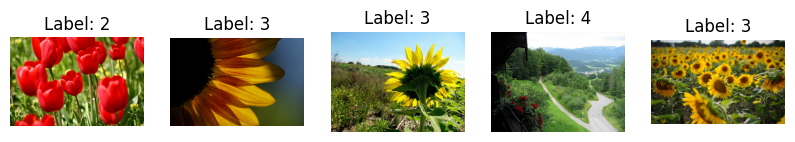

Train Dataset Size after preprocessing: 94
Validation Dataset Size after preprocessing: 21
Epoch 1/10
94/94 [==============================] - 219s 2s/step - loss: 1.5123 - accuracy: 0.4150 - val_loss: 1.2247 - val_accuracy: 0.4299
Epoch 2/10
91/94 [============================>.] - ETA: 6s - loss: 1.1106 - accuracy: 0.5549

In [ ]:
from google.colab import files
uploaded = files.upload()  # Abre un cuadro de diálogo para cargar un archivo

import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt  # Importa las bibliotecas necesarias para el procesamiento y visualización

# Carga el conjunto de datos de flores
dataset, info = tfds.load('tf_flowers', with_info=True, as_supervised=True)

# Muestra información sobre el conjunto de datos
print(info)

def visualize_images(dataset, num_images=5):
    """Función para visualizar algunas imágenes del conjunto de datos"""
    plt.figure(figsize=(10, 10))  # Configura la figura para mostrar las imágenes
    for i, (image, label) in enumerate(dataset.take(num_images)):  # Toma 'num_images' imágenes
        plt.subplot(1, num_images, i + 1)  # Crea subgráficas para cada imagen
        plt.imshow(image)  # Muestra la imagen
        plt.title(f"Label: {label}")  # Muestra la etiqueta de la imagen como título
        plt.axis('off')  # Elimina los ejes de la imagen
    plt.show()  # Muestra las imágenes

visualize_images(dataset['train'])  # Visualiza 5 imágenes del conjunto de entrenamiento

def preprocess_image(image, label):
    """Función para preprocesar imágenes"""
    image = tf.image.resize(image, [180, 180])  # Redimensiona la imagen a 180x180 píxeles
    image = image / 255.0  # Normaliza la imagen a valores entre 0 y 1
    return image, label  # Devuelve la imagen preprocesada y su etiqueta

# Crear conjuntos de entrenamiento y validación
train_dataset = dataset['train'].shuffle(1000).take(3000)  # Mezcla y toma las primeras 3000 imágenes para entrenamiento
val_dataset = dataset['train'].skip(3000)  # Usa el resto para validación

# Preprocesar y agrupar en lotes de 32 imágenes
train_dataset = train_dataset.map(preprocess_image).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.map(preprocess_image).batch(32).prefetch(tf.data.AUTOTUNE)

# Verificar el tamaño de los conjuntos después del preprocesamiento
print(f"Train Dataset Size after preprocessing: {tf.data.experimental.cardinality(train_dataset)}")
print(f"Validation Dataset Size after preprocessing: {tf.data.experimental.cardinality(val_dataset)}")

# Definición del modelo CNN
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(180, 180, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),  # Capa de pooling
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),  # Aplana las características para pasar a las capas densas
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')  # Capa de salida con 5 clases
])

# Compilación del modelo
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset)

# Evaluación del modelo en el conjunto de validación
val_loss, val_accuracy = model.evaluate(val_dataset)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

# Graficar precisión y pérdida durante el entrenamiento
def plot_history(history):
    """Función para graficar precisión y pérdida"""
    plt.figure(figsize=(12, 4))

    # Gráfico de la precisión
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Entrenamiento')
    plt.plot(history.history['val_accuracy'], label='Validación')
    plt.title('Precisión')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.legend()

    # Gráfico de la pérdida
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Entrenamiento')
    plt.plot(history.history['val_loss'], label='Validación')
    plt.title('Pérdida')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()

    plt.show()

plot_history(history)  # Mostrar los gráficos

# Función para predecir la clase de una nueva imagen
def predict_image(image_path, model):
    """Función para realizar predicciones sobre una nueva imagen"""
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=(180, 180))  # Cargar y redimensionar imagen
    image = tf.keras.preprocessing.image.img_to_array(image)  # Convertir imagen a arreglo
    image = tf.expand_dims(image, 0)  # Añadir dimensión para el batch

    image = image / 255.0  # Normalizar la imagen

    predictions = model.predict(image)  # Hacer la predicción
    predicted_class = tf.argmax(predictions[0]).numpy()  # Obtener la clase predicha
    return predicted_class, predictions[0][predicted_class]  # Devolver la clase y la probabilidad

# Ruta de la imagen cargada
image_path = 'descarga.jpg'  # Nombre de la imagen cargada

# Predecir la clase de la imagen
predicted_class, confidence = predict_image(image_path, model)
print(f"Predicted class: {predicted_class}, Confidence: {confidence:.2f}")  # Mostrar la clase y confianza

"""Las diferencias clave entre los modelos de clasificación de flores y perros y gatos son:

Número de clases: En el modelo de flores (tf_flowers) hay 5 clases, mientras que en el de perros y gatos solo hay 2 (perro y gato).
Variabilidad de imágenes: Las imágenes de flores suelen ser más variadas debido a los diferentes tipos de flores, mientras que las de perros y gatos son más homogéneas.
Tamaño del dataset: El dataset de flores tiene más clases, lo que hace que el modelo sea más complejo en comparación con el de perros y gatos."""

